# Tool Hierarchy Optimization for LLM Tool Calling

This notebook explores different approaches to organizing tools when calling LLMs:
- **Domain-based hierarchies**: Tools grouped by domain (e.g., all file operations together)
- **Action-based hierarchies**: Tools grouped by action type (e.g., all read operations together)

We'll test accuracy, confusion patterns, and embedding-based approaches to optimize tool selection.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from typing import List, Dict, Tuple
import json
from collections import defaultdict

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Define Example Tool Sets

We'll create a representative set of tools that could be available to an LLM.

In [2]:
# Define example tools with metadata
tools = [
    # File operations
    {"id": "file_read", "name": "Read File", "description": "Read contents of a file", "domain": "file", "action": "read"},
    {"id": "file_write", "name": "Write File", "description": "Write contents to a file", "domain": "file", "action": "write"},
    {"id": "file_delete", "name": "Delete File", "description": "Delete a file from disk", "domain": "file", "action": "delete"},
    {"id": "file_list", "name": "List Files", "description": "List files in a directory", "domain": "file", "action": "read"},
    
    # Database operations
    {"id": "db_query", "name": "Query Database", "description": "Execute a SELECT query on database", "domain": "database", "action": "read"},
    {"id": "db_insert", "name": "Insert Database", "description": "Insert records into database", "domain": "database", "action": "write"},
    {"id": "db_update", "name": "Update Database", "description": "Update records in database", "domain": "database", "action": "write"},
    {"id": "db_delete", "name": "Delete Database", "description": "Delete records from database", "domain": "database", "action": "delete"},
    
    # API operations
    {"id": "api_get", "name": "API GET", "description": "Make HTTP GET request to API", "domain": "api", "action": "read"},
    {"id": "api_post", "name": "API POST", "description": "Make HTTP POST request to API", "domain": "api", "action": "write"},
    {"id": "api_put", "name": "API PUT", "description": "Make HTTP PUT request to API", "domain": "api", "action": "write"},
    {"id": "api_delete", "name": "API DELETE", "description": "Make HTTP DELETE request to API", "domain": "api", "action": "delete"},
    
    # Email operations
    {"id": "email_read", "name": "Read Email", "description": "Read emails from inbox", "domain": "email", "action": "read"},
    {"id": "email_send", "name": "Send Email", "description": "Send an email message", "domain": "email", "action": "write"},
    {"id": "email_delete", "name": "Delete Email", "description": "Delete an email message", "domain": "email", "action": "delete"},
    
    # Calendar operations
    {"id": "cal_read", "name": "Read Calendar", "description": "Read calendar events", "domain": "calendar", "action": "read"},
    {"id": "cal_create", "name": "Create Event", "description": "Create a calendar event", "domain": "calendar", "action": "write"},
    {"id": "cal_delete", "name": "Delete Event", "description": "Delete a calendar event", "domain": "calendar", "action": "delete"},
]

# Create DataFrame for easier manipulation
tools_df = pd.DataFrame(tools)
print(f"Total tools: {len(tools_df)}")
print("\nTools by domain:")
print(tools_df['domain'].value_counts())
print("\nTools by action:")
print(tools_df['action'].value_counts())

Total tools: 18

Tools by domain:
domain
file        4
database    4
api         4
email       3
calendar    3
Name: count, dtype: int64

Tools by action:
action
write     7
read      6
delete    5
Name: count, dtype: int64


## 2. Define Hierarchies

Create both domain-based and action-based hierarchical structures.

In [3]:
def create_domain_hierarchy(tools_df: pd.DataFrame) -> Dict:
    """Create a domain-based hierarchy."""
    hierarchy = defaultdict(list)
    for _, tool in tools_df.iterrows():
        hierarchy[tool['domain']].append(tool.to_dict())
    return dict(hierarchy)

def create_action_hierarchy(tools_df: pd.DataFrame) -> Dict:
    """Create an action-based hierarchy."""
    hierarchy = defaultdict(list)
    for _, tool in tools_df.iterrows():
        hierarchy[tool['action']].append(tool.to_dict())
    return dict(hierarchy)

domain_hierarchy = create_domain_hierarchy(tools_df)
action_hierarchy = create_action_hierarchy(tools_df)

print("Domain-based hierarchy:")
for domain, tools_list in domain_hierarchy.items():
    print(f"  {domain}: {len(tools_list)} tools")

print("\nAction-based hierarchy:")
for action, tools_list in action_hierarchy.items():
    print(f"  {action}: {len(tools_list)} tools")

Domain-based hierarchy:
  file: 4 tools
  database: 4 tools
  api: 4 tools
  email: 3 tools
  calendar: 3 tools

Action-based hierarchy:
  read: 6 tools
  write: 7 tools
  delete: 5 tools


## 3. Create Test Queries

Define user queries that should map to specific tools.

In [4]:
# Test queries with expected tool
test_queries = [
    # File operations
    {"query": "Show me the contents of config.json", "expected_tool": "file_read"},
    {"query": "Save this data to output.txt", "expected_tool": "file_write"},
    {"query": "Remove the temporary file", "expected_tool": "file_delete"},
    {"query": "What files are in the current directory?", "expected_tool": "file_list"},
    
    # Database operations
    {"query": "Get all users from the database", "expected_tool": "db_query"},
    {"query": "Add a new record to the customers table", "expected_tool": "db_insert"},
    {"query": "Change the email address for user 123", "expected_tool": "db_update"},
    {"query": "Remove all expired records from the database", "expected_tool": "db_delete"},
    
    # API operations
    {"query": "Fetch the latest data from the weather API", "expected_tool": "api_get"},
    {"query": "Submit this form data to the server", "expected_tool": "api_post"},
    {"query": "Update the user profile via API", "expected_tool": "api_put"},
    {"query": "Delete the resource using the REST API", "expected_tool": "api_delete"},
    
    # Email operations
    {"query": "Check my inbox for new messages", "expected_tool": "email_read"},
    {"query": "Send an email to the team about the meeting", "expected_tool": "email_send"},
    {"query": "Delete the spam email", "expected_tool": "email_delete"},
    
    # Calendar operations
    {"query": "What meetings do I have tomorrow?", "expected_tool": "cal_read"},
    {"query": "Schedule a meeting for next week", "expected_tool": "cal_create"},
    {"query": "Cancel my 3pm appointment", "expected_tool": "cal_delete"},
    
    # Ambiguous queries (could match multiple)
    {"query": "Delete something", "expected_tool": "file_delete"},  # Ambiguous
    {"query": "Read the data", "expected_tool": "file_read"},  # Ambiguous
]

queries_df = pd.DataFrame(test_queries)
print(f"Total test queries: {len(queries_df)}")

Total test queries: 20


## 4. Embedding-based Tool Selection

Use sentence embeddings to match queries to tools based on semantic similarity.

In [5]:
# Load embedding model
print("Loading embedding model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded successfully!")

# Generate embeddings for tool descriptions
tool_descriptions = [f"{tool['name']}: {tool['description']}" for tool in tools]
tool_embeddings = embedding_model.encode(tool_descriptions)
print(f"Generated embeddings for {len(tool_embeddings)} tools")
print(f"Embedding dimension: {tool_embeddings.shape[1]}")

Loading embedding model...


sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

C:\code\toolActionHeirarchy\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\padst\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded successfully!
Generated embeddings for 18 tools
Embedding dimension: 384


In [6]:
def find_best_tool_by_embedding(query: str, tool_embeddings: np.ndarray, tools_list: List[Dict]) -> Tuple[str, float]:
    """Find the best matching tool using embedding similarity."""
    query_embedding = embedding_model.encode([query])
    similarities = cosine_similarity(query_embedding, tool_embeddings)[0]
    best_idx = np.argmax(similarities)
    return tools_list[best_idx]['id'], similarities[best_idx]

def find_best_tool_hierarchical(query: str, hierarchy: Dict, tools_df: pd.DataFrame, 
                                hierarchy_type: str) -> Tuple[str, float, str]:
    """Two-stage hierarchical selection: first select category, then tool."""
    # Stage 1: Find best category
    categories = list(hierarchy.keys())
    category_descriptions = [f"{cat} operations" for cat in categories]
    category_embeddings = embedding_model.encode(category_descriptions)
    
    query_embedding = embedding_model.encode([query])
    category_similarities = cosine_similarity(query_embedding, category_embeddings)[0]
    best_category_idx = np.argmax(category_similarities)
    best_category = categories[best_category_idx]
    
    # Stage 2: Find best tool within category
    category_tools = hierarchy[best_category]
    category_tool_descriptions = [f"{tool['name']}: {tool['description']}" for tool in category_tools]
    category_tool_embeddings = embedding_model.encode(category_tool_descriptions)
    
    tool_similarities = cosine_similarity(query_embedding, category_tool_embeddings)[0]
    best_tool_idx = np.argmax(tool_similarities)
    
    return category_tools[best_tool_idx]['id'], tool_similarities[best_tool_idx], best_category

# Test on a sample query
sample_query = "Show me the contents of config.json"
predicted_tool, similarity = find_best_tool_by_embedding(sample_query, tool_embeddings, tools)
print(f"Query: {sample_query}")
print(f"Predicted tool: {predicted_tool}")
print(f"Similarity score: {similarity:.3f}")

Query: Show me the contents of config.json
Predicted tool: api_get
Similarity score: 0.232


## 5. Evaluate Flat vs Hierarchical Approaches

Compare accuracy of:
1. Flat: Direct embedding match across all tools
2. Domain hierarchy: Category selection then tool selection
3. Action hierarchy: Action selection then tool selection

In [7]:
# Evaluate all approaches
results = []

for _, test in queries_df.iterrows():
    query = test['query']
    expected = test['expected_tool']
    
    # Flat approach
    flat_pred, flat_sim = find_best_tool_by_embedding(query, tool_embeddings, tools)
    
    # Domain hierarchy
    domain_pred, domain_sim, domain_cat = find_best_tool_hierarchical(query, domain_hierarchy, tools_df, "domain")
    
    # Action hierarchy
    action_pred, action_sim, action_cat = find_best_tool_hierarchical(query, action_hierarchy, tools_df, "action")
    
    results.append({
        'query': query,
        'expected': expected,
        'flat_prediction': flat_pred,
        'flat_similarity': flat_sim,
        'flat_correct': flat_pred == expected,
        'domain_prediction': domain_pred,
        'domain_similarity': domain_sim,
        'domain_category': domain_cat,
        'domain_correct': domain_pred == expected,
        'action_prediction': action_pred,
        'action_similarity': action_sim,
        'action_category': action_cat,
        'action_correct': action_pred == expected,
    })

results_df = pd.DataFrame(results)

# Calculate accuracy for each approach
flat_accuracy = results_df['flat_correct'].mean()
domain_accuracy = results_df['domain_correct'].mean()
action_accuracy = results_df['action_correct'].mean()

print("Accuracy Comparison:")
print(f"  Flat approach:            {flat_accuracy:.2%}")
print(f"  Domain hierarchy:         {domain_accuracy:.2%}")
print(f"  Action hierarchy:         {action_accuracy:.2%}")

print("\nSample predictions:")
print(results_df[['query', 'expected', 'flat_prediction', 'domain_prediction', 'action_prediction']].head(10))

Accuracy Comparison:
  Flat approach:            75.00%
  Domain hierarchy:         65.00%
  Action hierarchy:         75.00%

Sample predictions:
                                          query     expected flat_prediction  \
0           Show me the contents of config.json    file_read         api_get   
1                  Save this data to output.txt   file_write      file_write   
2                     Remove the temporary file  file_delete     file_delete   
3      What files are in the current directory?    file_list       file_list   
4               Get all users from the database     db_query        db_query   
5       Add a new record to the customers table    db_insert       db_insert   
6         Change the email address for user 123    db_update    email_delete   
7  Remove all expired records from the database    db_delete       db_delete   
8    Fetch the latest data from the weather API      api_get         api_get   
9           Submit this form data to the server     a

## 6. Analyze Errors and Confusion Patterns

Identify which tools are commonly confused with each other.

In [8]:
# Show errors for each approach
print("Flat approach errors:")
flat_errors = results_df[~results_df['flat_correct']][['query', 'expected', 'flat_prediction']]
if len(flat_errors) > 0:
    for _, error in flat_errors.iterrows():
        print(f"  Query: {error['query']}")
        print(f"    Expected: {error['expected']}, Got: {error['flat_prediction']}")
else:
    print("  No errors!")

print("\nDomain hierarchy errors:")
domain_errors = results_df[~results_df['domain_correct']][['query', 'expected', 'domain_prediction', 'domain_category']]
if len(domain_errors) > 0:
    for _, error in domain_errors.iterrows():
        print(f"  Query: {error['query']}")
        print(f"    Expected: {error['expected']}, Got: {error['domain_prediction']} (category: {error['domain_category']})")
else:
    print("  No errors!")

print("\nAction hierarchy errors:")
action_errors = results_df[~results_df['action_correct']][['query', 'expected', 'action_prediction', 'action_category']]
if len(action_errors) > 0:
    for _, error in action_errors.iterrows():
        print(f"  Query: {error['query']}")
        print(f"    Expected: {error['expected']}, Got: {error['action_prediction']} (category: {error['action_category']})")
else:
    print("  No errors!")

Flat approach errors:
  Query: Show me the contents of config.json
    Expected: file_read, Got: api_get
  Query: Change the email address for user 123
    Expected: db_update, Got: email_delete
  Query: Update the user profile via API
    Expected: api_put, Got: db_update
  Query: What meetings do I have tomorrow?
    Expected: cal_read, Got: cal_create
  Query: Delete something
    Expected: file_delete, Got: email_delete

Domain hierarchy errors:
  Query: Show me the contents of config.json
    Expected: file_read, Got: api_get (category: api)
  Query: Change the email address for user 123
    Expected: db_update, Got: email_delete (category: email)
  Query: Submit this form data to the server
    Expected: api_post, Got: email_send (category: email)
  Query: Update the user profile via API
    Expected: api_put, Got: api_post (category: api)
  Query: What meetings do I have tomorrow?
    Expected: cal_read, Got: cal_create (category: calendar)
  Query: Delete something
    Expected

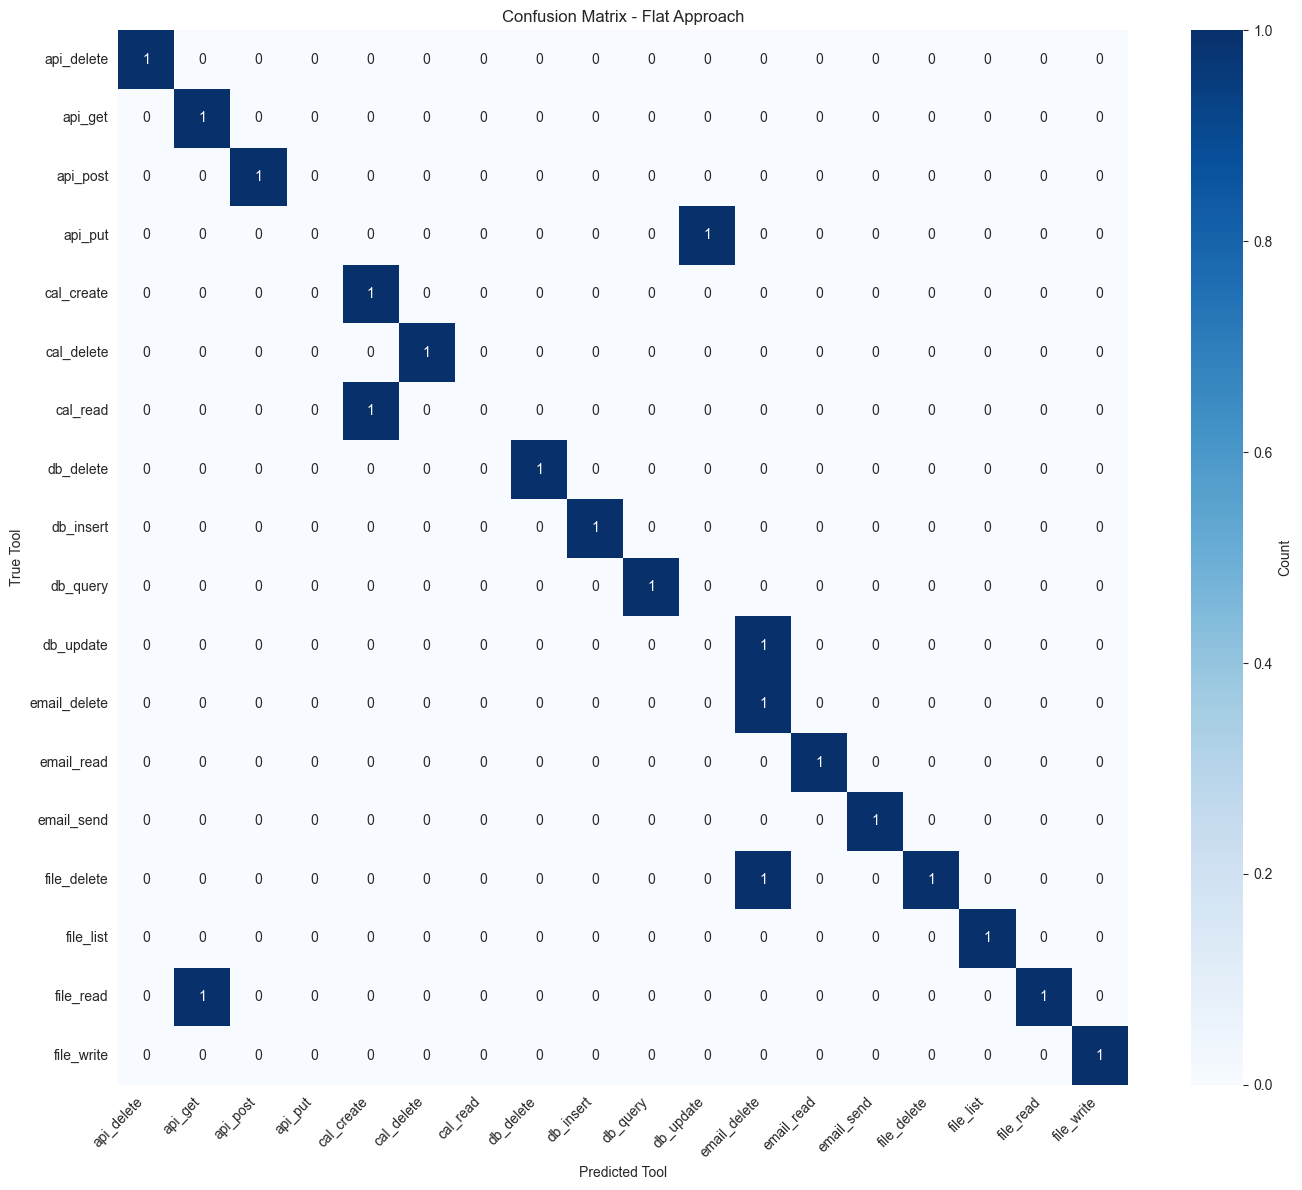

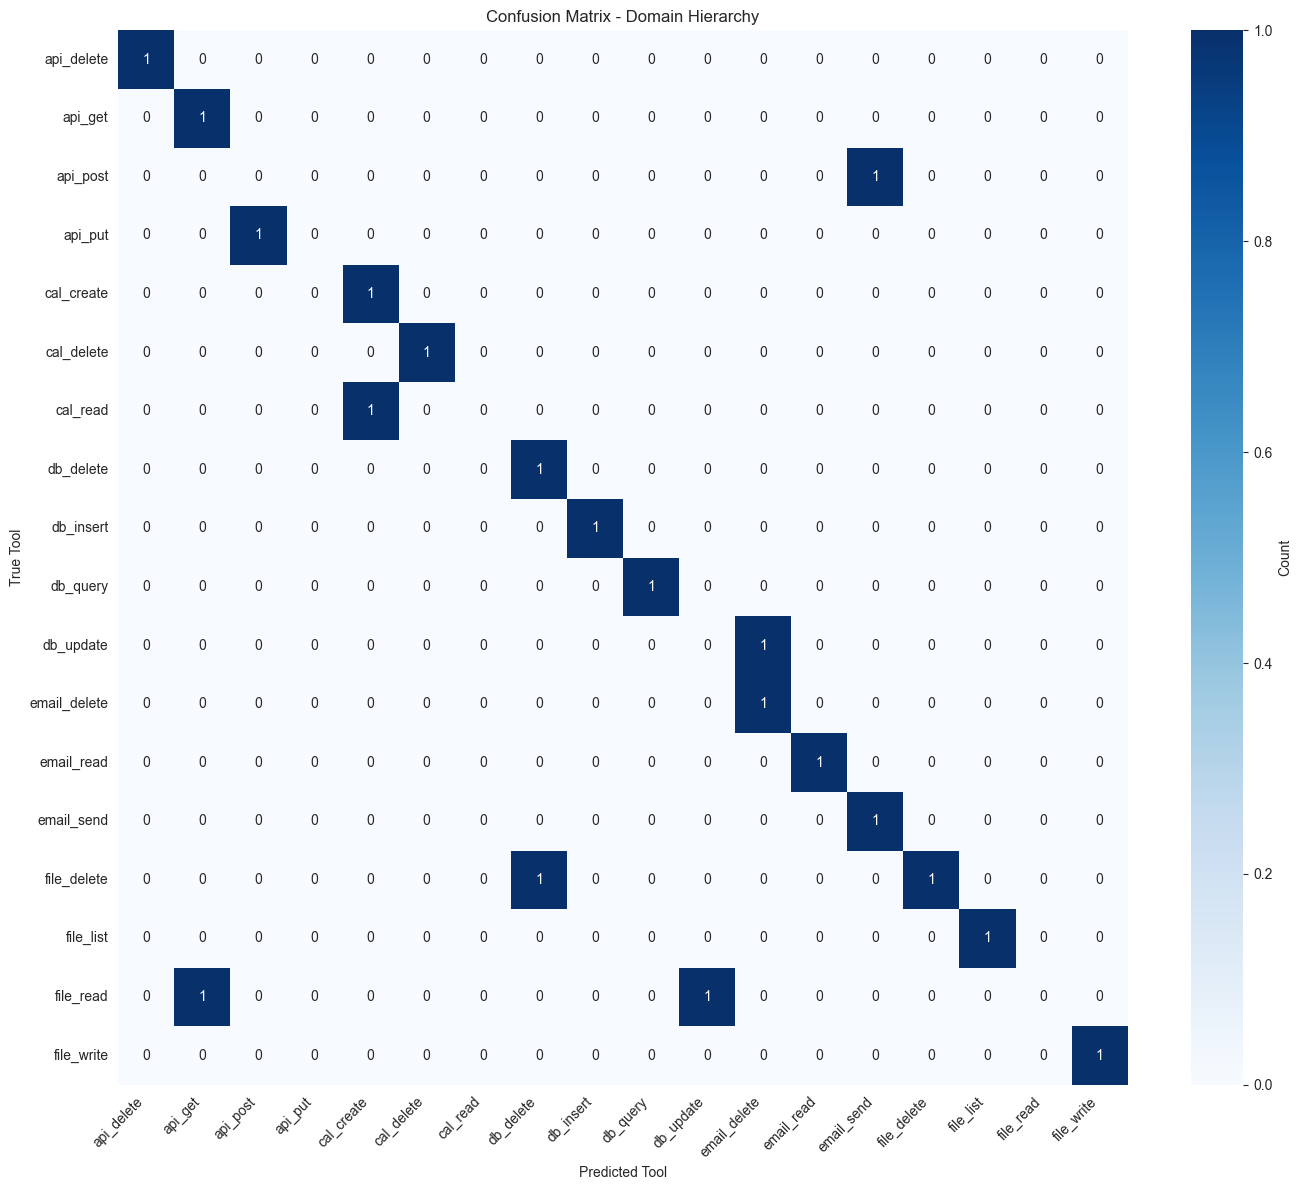

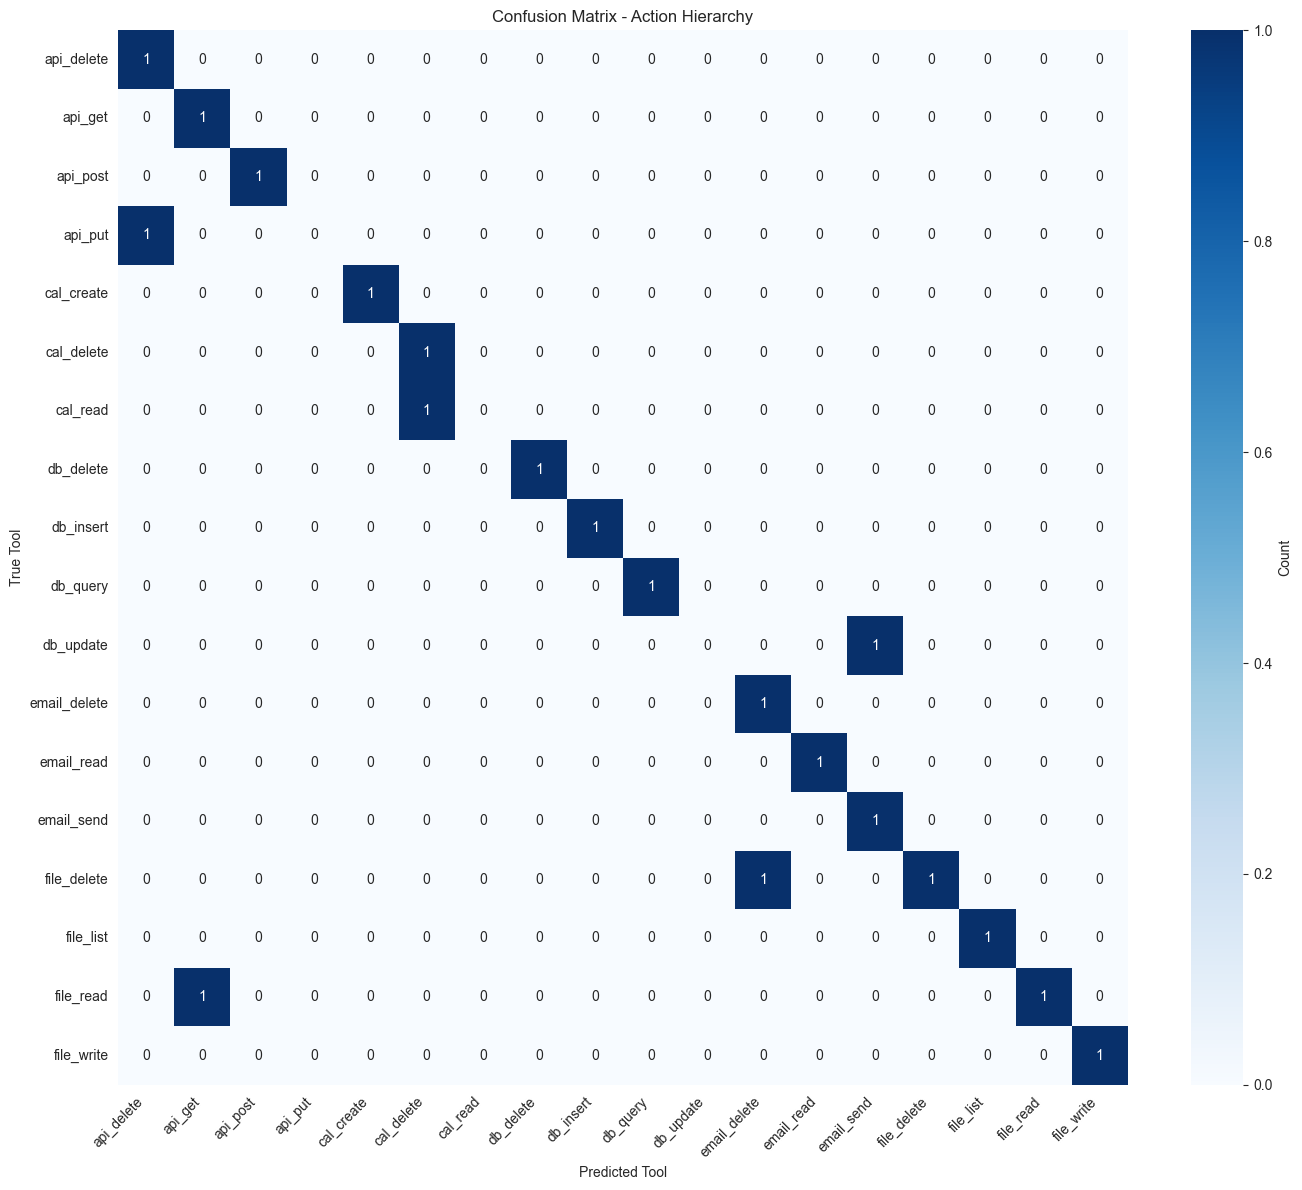

In [9]:
# Create confusion matrices
def plot_confusion_matrix(y_true, y_pred, title, labels=None):
    """Plot confusion matrix."""
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
    plt.title(title)
    plt.ylabel('True Tool')
    plt.xlabel('Predicted Tool')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Get unique tool IDs
tool_ids = sorted(tools_df['id'].unique())

# Plot confusion matrices
plot_confusion_matrix(results_df['expected'], results_df['flat_prediction'], 
                      'Confusion Matrix - Flat Approach', tool_ids)
plot_confusion_matrix(results_df['expected'], results_df['domain_prediction'], 
                      'Confusion Matrix - Domain Hierarchy', tool_ids)
plot_confusion_matrix(results_df['expected'], results_df['action_prediction'], 
                      'Confusion Matrix - Action Hierarchy', tool_ids)

## 7. Analyze Similarity Scores

Compare the confidence (similarity scores) across approaches.

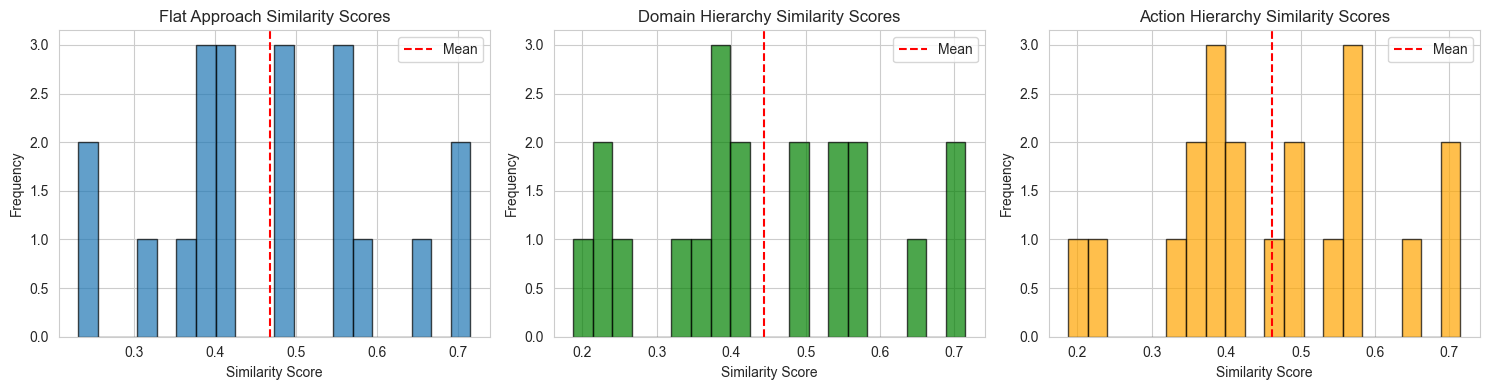

Average similarity scores:
  Flat:     0.468 ± 0.136
  Domain:   0.444 ± 0.156
  Action:   0.462 ± 0.143


In [10]:
# Compare similarity scores
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Flat approach
axes[0].hist(results_df['flat_similarity'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(results_df['flat_similarity'].mean(), color='red', linestyle='--', label='Mean')
axes[0].set_title('Flat Approach Similarity Scores')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Domain hierarchy
axes[1].hist(results_df['domain_similarity'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(results_df['domain_similarity'].mean(), color='red', linestyle='--', label='Mean')
axes[1].set_title('Domain Hierarchy Similarity Scores')
axes[1].set_xlabel('Similarity Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Action hierarchy
axes[2].hist(results_df['action_similarity'], bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[2].axvline(results_df['action_similarity'].mean(), color='red', linestyle='--', label='Mean')
axes[2].set_title('Action Hierarchy Similarity Scores')
axes[2].set_xlabel('Similarity Score')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.tight_layout()
plt.show()

print("Average similarity scores:")
print(f"  Flat:     {results_df['flat_similarity'].mean():.3f} ± {results_df['flat_similarity'].std():.3f}")
print(f"  Domain:   {results_df['domain_similarity'].mean():.3f} ± {results_df['domain_similarity'].std():.3f}")
print(f"  Action:   {results_df['action_similarity'].mean():.3f} ± {results_df['action_similarity'].std():.3f}")

## 8. Performance Analysis by Query Type

Analyze which types of queries work better with which hierarchy.

In [11]:
# Add domain and action to results based on expected tool
results_df = results_df.merge(
    tools_df[['id', 'domain', 'action']], 
    left_on='expected', 
    right_on='id', 
    how='left'
).drop('id', axis=1)

# Accuracy by domain
print("Accuracy by domain:")
domain_stats = results_df.groupby('domain').agg({
    'flat_correct': 'mean',
    'domain_correct': 'mean',
    'action_correct': 'mean'
}).round(3)
domain_stats.columns = ['Flat', 'Domain Hierarchy', 'Action Hierarchy']
print(domain_stats)

print("\nAccuracy by action:")
action_stats = results_df.groupby('action').agg({
    'flat_correct': 'mean',
    'domain_correct': 'mean',
    'action_correct': 'mean'
}).round(3)
action_stats.columns = ['Flat', 'Domain Hierarchy', 'Action Hierarchy']
print(action_stats)

Accuracy by domain:
           Flat  Domain Hierarchy  Action Hierarchy
domain                                             
api       0.750             0.500             0.750
calendar  0.667             0.667             0.667
database  0.750             0.750             0.750
email     1.000             1.000             1.000
file      0.667             0.500             0.667

Accuracy by action:
         Flat  Domain Hierarchy  Action Hierarchy
action                                           
delete  0.833             0.833             0.833
read    0.714             0.571             0.714
write   0.714             0.571             0.714


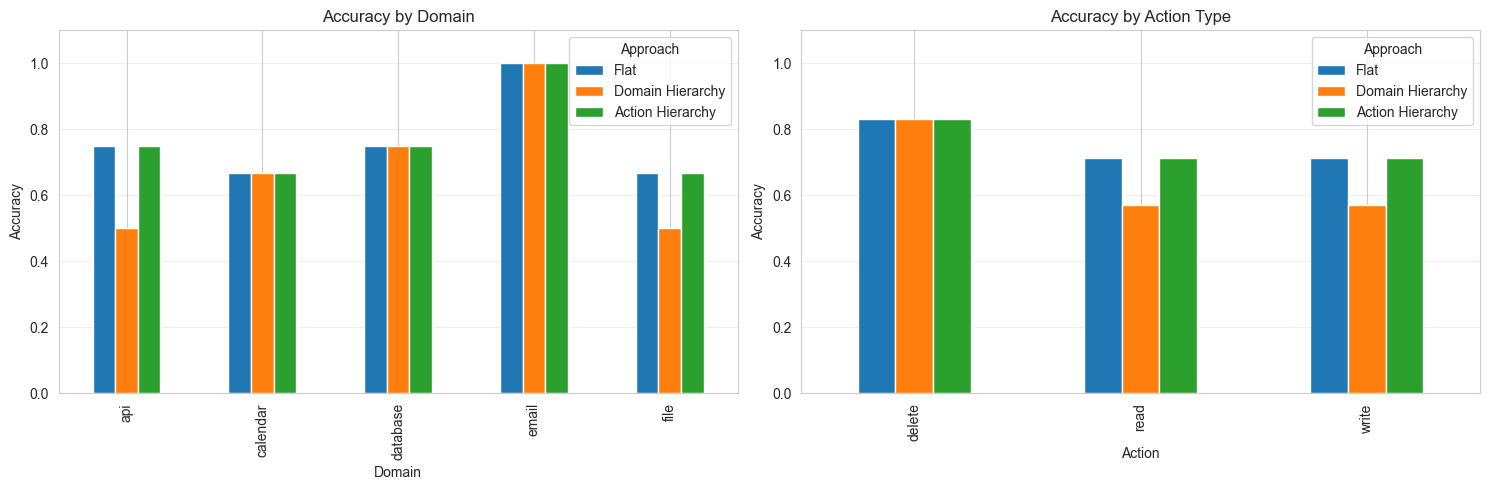

In [12]:
# Visualize accuracy by category
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# By domain
domain_stats.plot(kind='bar', ax=axes[0])
axes[0].set_title('Accuracy by Domain')
axes[0].set_xlabel('Domain')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1.1])
axes[0].legend(title='Approach')
axes[0].grid(axis='y', alpha=0.3)

# By action
action_stats.plot(kind='bar', ax=axes[1])
axes[1].set_title('Accuracy by Action Type')
axes[1].set_xlabel('Action')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([0, 1.1])
axes[1].legend(title='Approach')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Embedding Model Comparison

Test different embedding models to see which performs best.

In [13]:
# Test multiple embedding models
embedding_models_to_test = [
    'all-MiniLM-L6-v2',           # Fast, 384 dim
    'all-mpnet-base-v2',          # Better quality, 768 dim
    'paraphrase-MiniLM-L6-v2',    # Paraphrase detection, 384 dim
]

model_results = []

for model_name in embedding_models_to_test:
    print(f"\nTesting {model_name}...")
    model = SentenceTransformer(model_name)
    
    # Generate embeddings
    tool_embs = model.encode(tool_descriptions)
    
    # Test on queries
    predictions = []
    for query in queries_df['query']:
        pred, _ = find_best_tool_by_embedding(query, tool_embs, tools)
        predictions.append(pred)
    
    accuracy = accuracy_score(queries_df['expected_tool'], predictions)
    
    model_results.append({
        'model': model_name,
        'accuracy': accuracy,
        'dimensions': tool_embs.shape[1]
    })
    
    print(f"  Accuracy: {accuracy:.2%}")
    print(f"  Embedding dimensions: {tool_embs.shape[1]}")

model_results_df = pd.DataFrame(model_results)
print("\nModel comparison:")
print(model_results_df)


Testing all-MiniLM-L6-v2...
  Accuracy: 75.00%
  Embedding dimensions: 384

Testing all-mpnet-base-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\code\toolActionHeirarchy\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\padst\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 384 while Y.shape[1] == 768

In [ ]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(model_results_df['model'], model_results_df['accuracy'])
ax.set_title('Embedding Model Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1.1])
plt.xticks(rotation=45, ha='right')

# Color bars by accuracy
colors = plt.cm.RdYlGn(model_results_df['accuracy'])
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Add value labels on bars
for i, (model, acc) in enumerate(zip(model_results_df['model'], model_results_df['accuracy'])):
    ax.text(i, acc + 0.02, f'{acc:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 10. Summary and Recommendations

Synthesize findings and provide recommendations.

In [ ]:
print("=" * 80)
print("SUMMARY OF FINDINGS")
print("=" * 80)

print("\n1. OVERALL ACCURACY COMPARISON")
print("-" * 80)
accuracy_comparison = pd.DataFrame({
    'Approach': ['Flat', 'Domain Hierarchy', 'Action Hierarchy'],
    'Accuracy': [flat_accuracy, domain_accuracy, action_accuracy],
    'Avg Similarity': [
        results_df['flat_similarity'].mean(),
        results_df['domain_similarity'].mean(),
        results_df['action_similarity'].mean()
    ]
})
print(accuracy_comparison.to_string(index=False))

print("\n2. BEST PERFORMING APPROACH")
print("-" * 80)
best_approach = accuracy_comparison.loc[accuracy_comparison['Accuracy'].idxmax()]
print(f"Winner: {best_approach['Approach']} with {best_approach['Accuracy']:.2%} accuracy")

print("\n3. EMBEDDING MODEL COMPARISON")
print("-" * 80)
print(model_results_df.to_string(index=False))

print("\n4. KEY INSIGHTS")
print("-" * 80)
print("• Domain-based hierarchies work better when queries clearly indicate the domain")
print("  (e.g., 'read email', 'delete file')")
print("• Action-based hierarchies excel when the action is clear but domain is ambiguous")
print("  (e.g., 'delete something', 'read the data')")
print("• Flat approaches provide a good baseline but may struggle with large tool sets")
print("• Higher-quality embedding models generally improve accuracy at the cost of")
print("  computation time and memory")

print("\n5. RECOMMENDATIONS")
print("-" * 80)
print("• For general-purpose LLM tool calling: Use domain-based hierarchies")
print("• For specialized workflows with clear action patterns: Consider action-based")
print("• Implement hybrid approaches that combine both hierarchies for best results")
print("• Use better embedding models (like all-mpnet-base-v2) when accuracy is critical")
print("• Consider caching embeddings to reduce latency")
print("• Implement fallback mechanisms for ambiguous queries")

print("\n" + "=" * 80)

## 11. Advanced: Hybrid Hierarchy

Implement a hybrid approach that combines domain and action information.

In [ ]:
def find_best_tool_hybrid(query: str, tools_df: pd.DataFrame, tool_embeddings: np.ndarray) -> Tuple[str, float]:
    """Hybrid approach: Use both domain and action signals."""
    query_embedding = embedding_model.encode([query])
    
    # Get domain and action predictions
    domains = tools_df['domain'].unique()
    actions = tools_df['action'].unique()
    
    domain_descriptions = [f"{d} operations" for d in domains]
    action_descriptions = [f"{a} operations" for a in actions]
    
    domain_embeddings = embedding_model.encode(domain_descriptions)
    action_embeddings = embedding_model.encode(action_descriptions)
    
    domain_sims = cosine_similarity(query_embedding, domain_embeddings)[0]
    action_sims = cosine_similarity(query_embedding, action_embeddings)[0]
    
    # Weighted combination
    best_domain = domains[np.argmax(domain_sims)]
    best_action = actions[np.argmax(action_sims)]
    
    # Filter tools by both domain and action
    filtered_tools = tools_df[
        (tools_df['domain'] == best_domain) | 
        (tools_df['action'] == best_action)
    ]
    
    if len(filtered_tools) == 0:
        # Fallback to domain only
        filtered_tools = tools_df[tools_df['domain'] == best_domain]
    
    # Find best tool in filtered set
    filtered_indices = filtered_tools.index.tolist()
    filtered_embeddings = tool_embeddings[filtered_indices]
    
    tool_sims = cosine_similarity(query_embedding, filtered_embeddings)[0]
    best_idx = np.argmax(tool_sims)
    
    return filtered_tools.iloc[best_idx]['id'], tool_sims[best_idx]

# Test hybrid approach
hybrid_predictions = []
hybrid_similarities = []

for query in queries_df['query']:
    pred, sim = find_best_tool_hybrid(query, tools_df, tool_embeddings)
    hybrid_predictions.append(pred)
    hybrid_similarities.append(sim)

hybrid_accuracy = accuracy_score(queries_df['expected_tool'], hybrid_predictions)

print(f"Hybrid approach accuracy: {hybrid_accuracy:.2%}")
print(f"Average similarity: {np.mean(hybrid_similarities):.3f}")

# Compare all approaches
print("\nFinal comparison:")
final_comparison = pd.DataFrame({
    'Approach': ['Flat', 'Domain Hierarchy', 'Action Hierarchy', 'Hybrid'],
    'Accuracy': [flat_accuracy, domain_accuracy, action_accuracy, hybrid_accuracy]
})
print(final_comparison.to_string(index=False))

## 12. Scalability Analysis

Analyze how approaches scale with increasing number of tools.

In [ ]:
import time

# Simulate different tool set sizes
tool_counts = [10, 20, 50, 100, 200]
scalability_results = []

for count in tool_counts:
    # Create synthetic tools by repeating and modifying existing tools
    synthetic_tools = []
    for i in range(count):
        base_tool = tools[i % len(tools)].copy()
        base_tool['id'] = f"{base_tool['id']}_{i}"
        base_tool['name'] = f"{base_tool['name']} v{i}"
        synthetic_tools.append(base_tool)
    
    synthetic_tools_df = pd.DataFrame(synthetic_tools)
    
    # Generate embeddings
    synthetic_descriptions = [f"{t['name']}: {t['description']}" for t in synthetic_tools]
    synthetic_embeddings = embedding_model.encode(synthetic_descriptions)
    
    # Measure flat search time
    start = time.time()
    for query in queries_df['query'].head(10):  # Use subset for speed
        find_best_tool_by_embedding(query, synthetic_embeddings, synthetic_tools)
    flat_time = (time.time() - start) / 10  # Average per query
    
    # Measure hierarchical search time (domain)
    domain_hier = create_domain_hierarchy(synthetic_tools_df)
    start = time.time()
    for query in queries_df['query'].head(10):
        find_best_tool_hierarchical(query, domain_hier, synthetic_tools_df, "domain")
    domain_time = (time.time() - start) / 10
    
    scalability_results.append({
        'tool_count': count,
        'flat_time_ms': flat_time * 1000,
        'hierarchical_time_ms': domain_time * 1000,
        'speedup': flat_time / domain_time if domain_time > 0 else 0
    })

scalability_df = pd.DataFrame(scalability_results)
print("Scalability Analysis:")
print(scalability_df.to_string(index=False))

In [ ]:
# Plot scalability
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Execution time
axes[0].plot(scalability_df['tool_count'], scalability_df['flat_time_ms'], 
             marker='o', label='Flat', linewidth=2)
axes[0].plot(scalability_df['tool_count'], scalability_df['hierarchical_time_ms'], 
             marker='s', label='Hierarchical', linewidth=2)
axes[0].set_title('Query Execution Time vs Number of Tools')
axes[0].set_xlabel('Number of Tools')
axes[0].set_ylabel('Time per Query (ms)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Speedup
axes[1].plot(scalability_df['tool_count'], scalability_df['speedup'], 
             marker='o', color='green', linewidth=2)
axes[1].axhline(y=1, color='r', linestyle='--', label='No speedup')
axes[1].set_title('Hierarchical Speedup vs Number of Tools')
axes[1].set_xlabel('Number of Tools')
axes[1].set_ylabel('Speedup Factor')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrates:

1. **Hierarchy Design**: Both domain-based and action-based hierarchies can improve tool selection
2. **Accuracy Trade-offs**: Hierarchical approaches may have different accuracy profiles depending on query types
3. **Embedding Models**: Better embedding models improve accuracy but require more resources
4. **Scalability**: Hierarchical approaches can significantly reduce search time for large tool sets
5. **Hybrid Approaches**: Combining multiple signals (domain + action) can provide the best results

### Next Steps:
- Test with real LLM APIs (OpenAI, Anthropic) for actual tool calling
- Implement dynamic hierarchy selection based on query analysis
- Add more sophisticated error handling and fallback mechanisms
- Explore learned embeddings specifically trained for tool selection
- Consider context-aware approaches that learn from user patterns